# Leveraging Uniswap subgraph to extract token pair information

We use **The Graph Explore** to access Uniswap subgraph and analyze the data related to UNI and WETH token pair. 

### Install dependencies

In [31]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Define global variables

In [32]:
ENDPOINT = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'

### Define private methods for querying

In [33]:
def _send_request(query, args=None):
    '''Make an API call to a given endpoint str, given a query str'''

    data = {'query': query, 'variables': args}
    
    try:
        r = requests.post(ENDPOINT, json=data)
    except requests.exceptions.HTTPError  as e:
        raise Exception('Error sending a request to {0}: {1}'.format(ENDPOINT, e.response.text))
    
    if r.status_code == 200:
        return r.json()
    else:
        raise Exception('Query failed - return code:{}.'.format(r.status_code))

In [34]:
 def _sanitize(response, key):
    '''Make sure the response dict can be parsed'''
    
    try:
        return response[key]
    except KeyError as e:
         raise Exception('Response cannot be parsed.'.format(e))

In [35]:
def _parse_token_list(response):
    '''Parse a response from the API request'''
    
    id_list = _sanitize(_sanitize(response, 'data'), 'tokens')
    
    token_list = []
    for id_item in id_list:
        token_list.append(id_item['id'])
    
    return token_list

### Query to find all token IDs for $UNI

In [36]:
def get_UNI_ids():
    '''Request UNI token id list and return a parsed list of the result'''
    
    query = """
    {
      tokens(where:{symbol:"UNI"}){
        id
      }
    }
    """
    return _parse_token_list(_send_request(query))


get_UNI_ids()

['0x0478d05f4960fa5c7880a6346a5dd10d894e87ef',
 '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984',
 '0x24382731129c7b77cf1fb744e509e32572fa4a45',
 '0x2730d6fdc86c95a74253beffaa8306b40fedecbb',
 '0x3158e7fdfeacd9cb6744fb922f68d83321c0da64',
 '0x3e370a6c8255b065bd42bc0ac9255b269cfcc172',
 '0x41870c93bc97221a741f955586bef5cfcfa186fa',
 '0x5644b9eed6f578c820e6fa500b3c9f21d22347d8',
 '0x8a3afc69b947b9368af68104fa3ac512b58b930e',
 '0x8b16acf50051bb6efd68bdf35099b798db0ff4b7',
 '0x907455194480175560b05a405f47d298cb19b21d',
 '0x9629aa8ce8e61004952ab619d683576f4ec5478b',
 '0xcae516aa57d04ebf9b92813050282333f7587d2f',
 '0xebfee807881a0258311aeae07e2e3ae49aa41f29',
 '0xf17785cce27f0d33b82739ee20abd57298caa88a']

### Query to find all token IDs for $WETH

In [37]:
def get_WETH_ids():
    ''' Request WETH token id list and return a parsed list of the result'''
    
    query = """
    {
      tokens(where:{symbol:"WETH"}){
        id
      }
    }
    """
    return _parse_token_list(_send_request(query))


get_WETH_ids()

['0x00965af6ddfd9171961e53f9f955c47521067ccc',
 '0x477b466750c31c890db3208816d60c8585be7f0e',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
 '0xd73d6d4c463df976399acd80ea338384e247c64b']

### Query to find IDs of all combinations of a pair of tokens

In [38]:
def get_pair_ids(token_list1, token_list2, token_sym1, token_sym2):
    '''Request pair IDs of all combinations of a pair of tokens'''
    
    pair_list = []
    response = ''
    
    query = """query($a: String!, $b: String!) 
      {
      pairs(where: {token0: $a, token1: $b })
        {
        id
        }
      }"""

    for token1 in token_list1:
        for token2 in token_list2:
            
            variables = {"a": token1, "b": token2}
            response = _send_request(query, variables)
            response = _sanitize(_sanitize(response, 'data'), 'pairs')
            
            if len(response) != 0:
                pair_list.append(_sanitize(response[0], 'id'))
    
    return pair_list


get_pair_ids(uni_list, weth_list, 'uni', 'weth')

['0x4330e23e6fb28882060c8a125c4f1d2400b7b2d9',
 '0xd3d2e2692501a5c9ca623199d38826e513033a17',
 '0x7c498db5cb65b398e118eda7e71ac7306e0e2923',
 '0x63ff582264aa89a1f870564985c0c871979a898e',
 '0x6c7e7a1706ad680fefeb470371e0871cc6d7b19a',
 '0xa47ea5b74b6879c52250794376443eebd8a17bb3',
 '0x822130268fba14006b92c4d13b8b6fe3196ea2f0',
 '0xf615e9d45b998f605a5c1e27839c46670717a931',
 '0x5e0c41ec47d6675560b8608d8779ba949c5d9153',
 '0xf05a0ec162a03585ab06a5e112eda9b0348d1da0',
 '0xec2915ad1e9ac5cf68dda0f3ebdafbc8b8f69bea',
 '0x5709341ce31136276108a38c1901a90e19ac1f79']

### Query to find recent swaps between the pairs (by their pair IDs)

In [39]:
def find_recent_swaps(pair_list):
    '''Query 1k recent swaps for a given list of pair IDs'''
    
    # the number of swaps is hardcoded in the query:
    query = """query($a: String!)
    {
    swaps(first:1000, orderBy: timestamp, orderDirection: desc, where:{ pair: $a }) 
    {
        pair {
          reserveUSD
          id
        }
        amount0In
        amount0Out
        amount1In
        amount1Out
        timestamp
        amountUSD
    }
    }
    """
    
    swaps = pd.DataFrame()
    
    for pair in pair_list:
        variables = {"a": pair}
        response = _send_request(query, variables)
        swaps = swaps.append(_sanitize(_sanitize(response, 'data'), 'swaps'), ignore_index=True)
        
    return swaps


swaps = find_recent_swaps(pair_list)

### Data cleaning and plotting

In [40]:
def data_cleaning(df):
    ''''''
    pool_id = []
    liquidity = []
    
    for item in range(len(df)):
        
      pool_id.append(_sanitize(_sanitize(_sanitize(df, 'pair'), item), 'id'))
      liquidity.append(_sanitize(_sanitize(_sanitize(df, 'pair'), item), 'reserveUSD'))
        
    df["TIMESTAMP"] = df["timestamp"]
    df['BASE CURRENCY QUANTITY TRADED'] = np.where((df['amount0In'] > df['amount0Out']), df['amount0In'], df['amount0Out'])
    df['QUOTE CURRENCY QUANTITY TRADED'] = np.where((df['amount1In'] > df['amount1Out']), df['amount1In'], df['amount1Out'])
    df['FREQ'] = np.where((df['amount0In'] > df['amount0Out']), "SELL", "BUY")
    df['VOLUME IN USD'] = df["amountUSD"]
    df = df.assign(POOL_ID = pool_id, LIQUIDITY_IN_POOL = liquidity)
    
    del df['amountUSD'],df["amount1Out"],df["pair"],df["timestamp"], df['amount0In'],df['amount0Out'],df['amount1In']
    df.astype({'BASE CURRENCY QUANTITY TRADED':float,'QUOTE CURRENCY QUANTITY TRADED':float,'VOLUME IN USD':float})
    df["time Stamp"] = pd.to_datetime(df['TIMESTAMP'], unit='s')
    del df["TIMESTAMP"]
    
    return df


data_cleaning(swaps)

,BASE CURRENCY QUANTITY TRADED,QUOTE CURRENCY QUANTITY TRADED,FREQ,VOLUME IN USD,POOL_ID,LIQUIDITY_IN_POOL,time Stamp
0,5.50970290763971213,0.08,BUY,30.55308544225965789904832090849591,0x4330e23e6fb28882060c8a125c4f1d2400b7b2d9,0.00000000000009270166726518542246770840448501383,2020-09-19 01:31:08
1,15,0.208334881832740216,BUY,80.60500517371023368012414053493041,0x4330e23e6fb28882060c8a125c4f1d2400b7b2d9,0.00000000000009270166726518542246770840448501383,2020-09-19 01:14:47
2,16.946378445231014027,0.22,BUY,85.35431466111416644824963917718701,0x4330e23e6fb28882060c8a125c4f1d2400b7b2d9,0.00000000000009270166726518542246770840448501383,2020-09-19 00:46:53
3,10,0.122817431887499233,BUY,47.290749463598840450431466394341,0x4330e23e6fb28882060c8a125c4f1d2400b7b2d9,0.00000000000009270166726518542246770840448501383,2020-09-19 00:46:04
4,8.514535129189000237,0.030814729043874558,SELL,84.47110311523129527541151444777806,0xd3d2e2692501a5c9ca623199d38826e513033a17,35103115.36224916245174609390303979,2022-02-19 23:21:17
...,...,...,...,...,...,...,...
1119,2000,1.071431896051017075,SELL,401.5593345812715054683210969378154,0x5709341ce31136276108a38c1901a90e19ac1f79,0.00000000000002355424209292357157384813377270777,2020-09-17 00:49:35
1120,1646.918584924192367448,0.916209672879891649,SELL,343.9506948745968709848058788226527,0x5709341ce31136276108a38c1901a90e19ac1f79,0.00000000000002355424209292357157384813377270777,2020-09-17 00:49:35
1121,175.95800172347654216,0.1,BUY,37.73058164433374422552063883292227,0x5709341ce31136276108a38c1901a90e19ac1f79,0.00000000000002355424209292357157384813377270777,2020-09-17 00:48:56
1122,4000,2.354760159498772741,SELL,868.850932245314331590806427454496,0x5709341ce31136276108a38c1901a90e19ac1f79,0.00000000000002355424209292357157384813377270777,2020-09-17 00:47:40


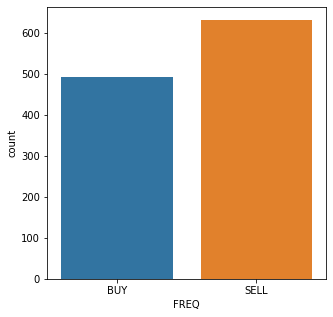

In [41]:
def plot_buy_or_sell(df):
    plt.figure(figsize=(5,5))
    ax = sns.countplot(x="FREQ", data=df)
    plt.show()
    
plot_buy_or_sell(swaps)